In [169]:
import sympy as sym
import numpy as np
import pygmo as pyg
import scipy
import matplotlib.pyplot as plt
from scipy import optimize
%matplotlib notebook

In [105]:
x  = sym.Symbol("x")
y = sym.Symbol("y")
Bird = -sym.sin(x) * sym.exp((1 - sym.cos(y)) ** 2) - sym.cos(y) * sym.exp((1 - sym.sin(x)) ** 2) - (x - y) ** 2
_dBird = sym.lambdify ([x,y], np.array([Bird.diff(x), Bird.diff(y)]), modules = ['numpy'])
def dBird(x,y):
    return np.array(_dBird(x,y))
Bird = sym.lambdify([x,y],np.array(Bird), modules = ['numpy'])
#print(sym.diff(Bird,x))
#print(sym.diff(Bird,y))

In [107]:
def grad(f, df, x0:np.ndarray, lr:float = 0.1, 
         eps:float = 1e-06, iterMax:int = 1e06):
    x = [x0[0]]
    y = [x0[1]]
    z = [f(*x0)]
    for i in range(int(iterMax)):
        x0 = x0 + lr * df(*x0)
        if (np.isnan(x0[0]) or np.isnan(x0[1])):
            print("Got Nan")
            break
        x.append(x0[0])
        y.append(x0[1])
        z.append(f(*x0))
        if np.linalg.norm(df(*x0)) < eps:
            break
    else:
        print("Iteration limit reached")
    return np.array(x), np.array(y), np.array(z)

In [ ]:
def Nu(t:int, a:float, exp:bool = False, T:int = 0):
    if T > 0:
        if exp:
            return a * np.exp(-t / T)
        return a * (1 - t / T)
    elif exp:
        return np.exp(-a * t ** 2)
    return a / t

In [ ]:
#Метод моментов
def gradImpuls(f, df, x0:np.ndarray, area:np.ndarray = np.array([[0, 0], [0, 0]]), lr:float = 0.5, etta:float = 0.5,
               eps:float = 1e-06, stop:int = 2, iterMax:int = 1e06, max:bool = True, NuB:bool = False, T:int = 0,
               exp:bool = False, nester:bool = False):
    x = [x0[0]]
    y = [x0[1]]
    z = [f(x0)]
    u0 = 0
    if not max:
        lr = -lr
        etta = -etta
    nu = lr
    for i in range(1, int(iterMax)):
        if NuB:
            nu = Nu(i, lr, exp, T)
        if nester:
            gradient = df(x0 - etta * u0)
        else:
            gradient = df(x0)
        u = etta * u0 + nu * gradient
        x0 = x0 + u
        u0 = u
        if (area[0][0] != area[1][0] or area[0][1] != area[1][1]) and \
           (x0[0] < area[0][0] or x0[0] > area[1][0] or x0[1] < area[0][1] or x0[1] > area[1][1]):
            print("Out of bounds!")
            break
        if (np.isnan(x0[0]) or np.isnan(x0[1])):
            print("You got nan!")
            break
        x.append(x0[0])
        y.append(x0[1])
        z.append(f(x0))
        if stop == 0:
            check = np.abs(x0 - np.array(x[-2], y[-2]))
            check = (check[0] < eps and check[1] < eps)
        elif stop == 1:
            check = np.abs(z[-1] - z[-2]) < eps
        else:
            check = np.linalg.norm(df(x0)) < eps
        if check:
            break
    if i == iterMax:
        print("Max iter done!")
    return np.array(x), np.array(y), np.array(z)

In [ ]:
#adadelta
def AdaGrad(f, df, x0:np.ndarray, area:np.ndarray = np.array([]), lr:float = 0.5, eps:float = 1e-06, stop:int = 2, 
            iterMax:int = 1e06, max:bool = True, NuB:bool = False, T:int = 0, exp:bool = False, eps2:float = 1e-06):
    x = []
    for i in x0:
        x.append([i])
    z = [f(x0)]
    G = np.zeros(len(x0))
    if not max:
        lr = -lr
    nu = lr
    outOfBounds = False
    isNun = False
    for i in range(int(iterMax)):
        if NuB:
            nu = Nu(i, lr, exp, T)
        g = df(x0)
        G = G + (g ** 2)
        x0 = x0 + nu / (np.sqrt(G + eps2)) * g
        if (area.size > 0):
            for j in range(len(x0)):
                if (x0[j] < area[j][0] or x0[j] > area[j][1]):
                    outOfBounds = True
                    break
            if outOfBounds:
                print("Out of bounds!")
                break
        for j in x0:
            if (np.isnan(j)):
                isNun = True
                break
        if isNun:
            print("You got nan!")
            break
        for i in range(len(x0)):
            x[i].append(x0[i])
        z.append(f(x0))
        if stop == 0:
            check = []
            for i in range(len(x0)):
                check.append(np.abs(x0[i] - np.array(x[i][-2])) < eps)
            check = np.allclose(np.array(check), np.full(len(x0), True))
        elif stop == 1:
            check = np.abs(z[-1] - z[-2]) < eps
        else:
            check = np.linalg.norm(df(x0)) < eps
        if check:
            break
    if i == iterMax:
        print("Max iter done!")
    return np.array(x), np.array(z)

In [ ]:
def Adam(f, df, x0:np.ndarray, area:np.ndarray = np.array([]), lr:float = 0.5, eps:float = 1e-06, stop:int = 2, 
         iterMax:int = 1e06, max:bool = True, NuB:bool = False, T:int = 0, exp:bool = False, eps2:float = 1e-06, 
         beta1:float = 0.9, beta2:float = 0.999):
    x = []
    for i in x0:
        x.append([i])
    z = [f(x0)]
    if not max:
        lr = -lr
    nu = lr
    outOfBounds = False
    isNun = False
    m = np.zeros(len(x0))
    v = np.zeros(len(x0))
    for i in range(int(iterMax)):
        if NuB:
            nu = Nu(i, lr, exp, T)
        g = df(x0)
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * (g ** 2)
        mHigh = m / (1 - beta1 ** (i + 1))
        vHigh = v / (1 - beta2 ** (i + 1))
        x0 = x0 + nu / (np.sqrt(vHigh + eps2)) * mHigh
        if (area.size > 0):
            for j in range(len(x0)):
                if (x0[j] < area[j][0] or x0[j] > area[j][1]):
                    outOfBounds = True
                    break
            if outOfBounds:
                print("Out of bounds!")
                break
        for j in x0:
            if (np.isnan(j)):
                isNun = True
                break
        if isNun:
            print("You got nan!")
            break
        for i in range(len(x0)):
            x[i].append(x0[i])
        z.append(f(x0))
        if stop == 0:
            check = []
            for i in range(len(x0)):
                check.append(np.abs(x0[i] - np.array(x[i][-2])) < eps)
            check = np.allclose(np.array(check), np.full(len(x0), True))
        elif stop == 1:
            check = np.abs(z[-1] - z[-2]) < eps
        else:
            check = np.linalg.norm(df(x0)) < eps
        if check:
            break
    if i == iterMax:
        print("Max iter done!")
    return np.array(x), np.array(z)

In [108]:
x1, y1, z1 = grad(Bird, f2, np.array([-1.5, 1.5]), lr = 0.1, iterMax = 1e05)

In [128]:
x = np.max(np.abs(x1)) + 1
y = np.max(np.abs(y1)) + 1
x = np.linspace(-x, x, int(2*x*10))
y = np.linspace(-y, y, int(2*y*10))
xgrid, ygrid = np.meshgrid(x,y)
zgrid = Bird(xgrid, ygrid)

<IPython.core.display.Javascript object>


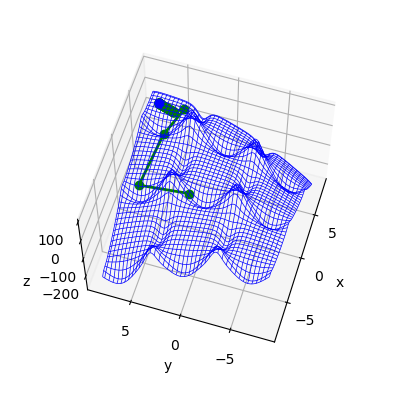

In [134]:
fig = plt.figure(figsize = (4,4))
ax3d = fig.add_subplot(projection='3d')
ax3d.plot_wireframe(xgrid,ygrid,zgrid, color = 'b', linewidth = 0.5)
ax3d.set_xlabel('x')
ax3d.set_ylabel('y')
ax3d.set_zlabel('z')
ax3d.plot(x1[:-1], y1[:-1], z1[:-1], '-ok', color = 'g', linewidth = 2)
ax3d.plot(x1[-1], y1[-1], z1[-1], '-ok', color = 'b', linewidth = 2)
plt.show()

<IPython.core.display.Javascript object>


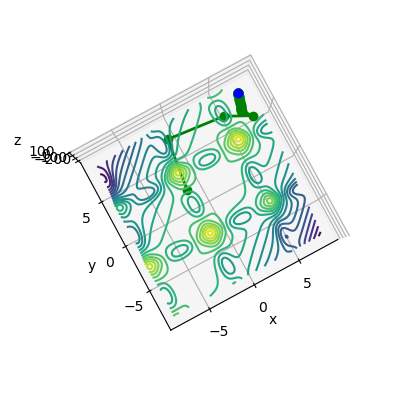

In [130]:
fig1 = plt.figure(figsize = (4,4))
ax3dlevel = fig1.add_subplot(projection='3d')
ax3dlevel.contour(xgrid, ygrid, zgrid, 20)
ax3dlevel.set_xlabel('x')
ax3dlevel.set_ylabel('y')
ax3dlevel.set_zlabel('z')
ax3dlevel.plot(x1, y1, z1, '-ok', color = 'g', linewidth = 2)
ax3dlevel.plot(x1[-1], y1[-1], z1[-1], '-ok', color = 'b', linewidth = 2)
plt.show()

<IPython.core.display.Javascript object>


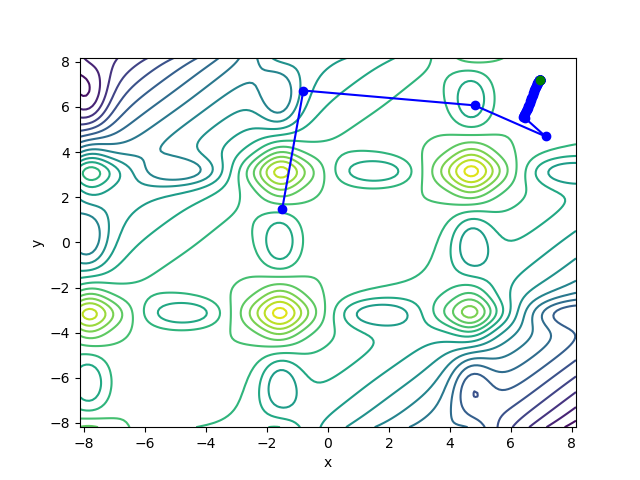

In [131]:
fig2, ax = plt.subplots()
ax.contour(xgrid, ygrid, zgrid, 20)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.plot(x1[:-1], y1[:-1], '-ok', color = 'b')
plt.plot(x1[-1], y1[-1], '-ok', color = 'g', linewidth = 2)
plt.show()

In [161]:
class Bird_problem:
    def __init__(self,pr,dim,lb,rb):
        self.fit_func = pr
        self.dim=dim
        self.lb=lb
        self.rb=rb

    def fitness(self, weights):
        return np.array([self.fit_func(*weights)])
    def get_bounds(self):
        return np.full((self.dim,),self.lb),np.full(self.dim,self.rb)

In [162]:
prob = pyg.problem(Bird_problem(Bird,2,-9,9))
print(prob)

Problem name: <class '__main__.Bird_problem'>
	Global dimension:			2
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [-9, -9]
	Upper bounds: [9, 9]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none



In [176]:
algo = pyg.algorithm(pyg.bee_colony(gen = 200, limit = 200))
pop = pyg.population(prob = prob, size = 1000, seed = 1)
pop = algo.evolve(pop)
print(pop.champion_f)

[1.23077644e-05]
